In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import roc_curve, auc
import umap
import pickle
import tqdm

from gptenrichment import genemap, enrichr

library = enrichr.get_library("GO_Biological_Process_2021")
library = genemap.remove_long_lists(library, 2000)
genes = list(set([element for sublist in library.values() for element in sublist]))
lib1, lib2 = genemap.split_lists(library, factor=3, overlap=True)
#print("True samples: ", len(lib1))


In [9]:
gene_lib = {}
for g in genes:
    gene_lib[g] = ["gene symbol: "+g]

gene_embedding = genemap.embed_library(gene_lib, progress=True)


100%|██████████| 290/290 [03:16<00:00,  1.48it/s]


In [11]:
library_embedding = genemap.embed_library(library, progress=True)

100%|██████████| 121/121 [01:22<00:00,  1.47it/s]


In [41]:
gold = []
miss = []
del X

for set_name in tqdm.tqdm(library_embedding.index):
    for i in range(10):
        random_gene = random.sample(library[set_name],1)[0]
        gene_to_set = np.array(gene_embedding.loc[random_gene,:] - library_embedding.loc[set_name,:])
        gold.append(gene_to_set)

for set_name in tqdm.tqdm(library_embedding.index):
    for i in range(30):
        random_gene = random.sample(genes,1)[0]
        gene_to_set = np.array(gene_embedding.loc[random_gene,:] - library_embedding.loc[set_name,:])
        miss.append(gene_to_set)

gold = np.array(gold)
miss = np.array(miss)
X = np.concatenate((gold, miss), axis=0)
X = pd.DataFrame(X, index=range(X.shape[0]))
y = np.array([1]*gold.shape[0] + [0]*miss.shape[0])

100%|██████████| 6034/6034 [00:14<00:00, 402.29it/s]


In [24]:
del gold
del miss

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gene_model = LGBMRegressor(seed=42)
gmod = gene_model.fit(X_train, y_train)

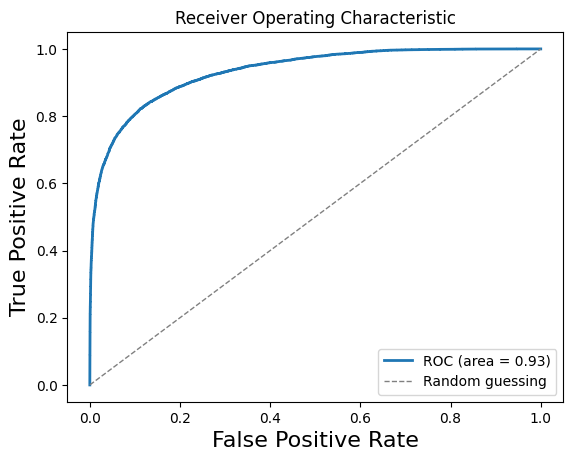

In [25]:
y_pred = gene_model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, lw=2, label='ROC (area = %0.2f)' % roc_auc)

# plot the random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')

# set the plot title and axis labels
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend()

# show the plot
plt.show()

100%|██████████| 6034/6034 [00:08<00:00, 691.69it/s]


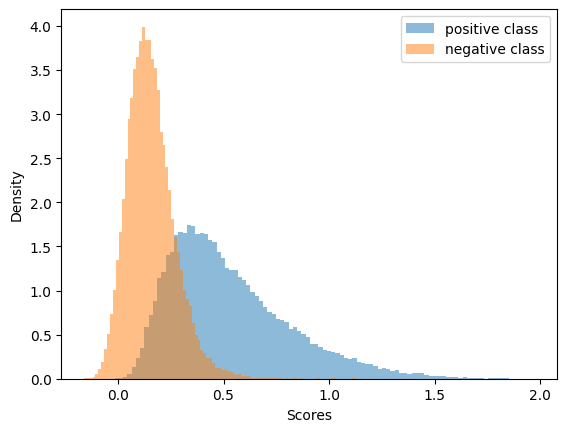

: 

In [45]:

gl = []
rl = []
for set_name in tqdm.tqdm(library_embedding.index):
    for lgene in random.sample(library[set_name], min(len(library[set_name]), 10)):
        gene_to_set = np.array(gene_embedding.loc[lgene,:] - library_embedding.loc[set_name,:])
        gl.append(gene_to_set)
        random_gene = random.sample(genes,1)[0]
        gene_to_set = np.array(gene_embedding.loc[random_gene,:] - library_embedding.loc[set_name,:])
        rl.append(gene_to_set)

y_pred_gold = gene_model.predict(np.array(gl))
y_pred_miss = gene_model.predict(np.array(rl))

plt.hist(y_pred_gold, bins=100, density=True, alpha=0.5, label='positive class')
plt.hist(y_pred_miss, bins=100, density=True, alpha=0.5, label='negative class')

# Adding labels and legend
plt.xlabel('Scores')
plt.ylabel('Density')
plt.legend()

In [39]:
len(y_pred_miss)

377

In [3]:
embedding1 = genemap.embed_library(lib1)
embedding2 = genemap.embed_library(lib2)

100%|██████████| 725/725 [05:49<00:00,  2.07it/s]


In [4]:
with open("data/embedding_1_gobp_3_over.pkl", "wb") as file:
    pickle.dump(embedding1, file)

with open("data/embedding_2_gobp_3_over.pkl", "wb") as file:
    pickle.dump(embedding2, file)

with open("data/gene_embedding.pkl", "wb") as file:
    pickle.dump(gene_embedding, file)

with open("data/gobp_embedding.pkl", "wb") as file:
    pickle.dump(library_embedding, file)

In [3]:
with open("data/embedding_1_gobp_3_over.pkl", "rb") as file:
    embedding1 = pickle.load(file)

with open("data/embedding_2_gobp_3_over.pkl", "rb") as file:
    embedding2 = pickle.load(file)

In [4]:
umod = umap.UMAP(n_components=2, init="random", random_state=1)
uu = umod.fit_transform(library_embedding)

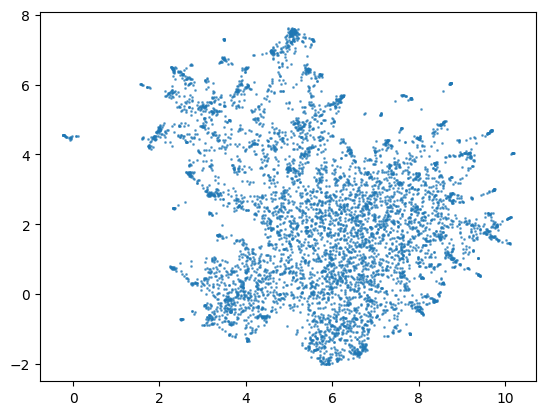

In [7]:
plt.scatter(uu[:,0], uu[:,1], s=1, alpha=0.6)

In [25]:
true_samples = []
false_samples = []

for k in range(embedding1.shape[0]):
    true_samples.append(np.concatenate((embedding1[k],embedding2[k])))

for i in range(82000):
    false_samples.append(np.concatenate((embedding1[random.randint(0,embedding1.shape[0]-1)],embedding2[random.randint(0,embedding1.shape[0]-1)])))

true_samples = np.array(true_samples)
false_samples = np.array(false_samples)

X = np.concatenate((true_samples, false_samples), axis=0)
y = np.array([1]*true_samples.shape[0] + [0]*false_samples.shape[0])


In [4]:
true_samples = []
false_samples = []
setsize_1 = [len(lib1[x])*2 for x in lib1]
setsize_2 = []

for k in range(embedding1.shape[0]):
    true_samples.append(embedding1[k] - embedding2[k])

for i in range(82000):
    r1 = random.randint(0,embedding1.shape[0]-1)
    r2 = random.randint(0,embedding1.shape[0]-1)
    #setsize_2.append((setsize_1[r1] + setsize_1[r2])/2)
    false_samples.append(embedding1[r1] - embedding2[r2])

#setsize = np.array(setsize_1+setsize_2)
true_samples = np.array(true_samples)
false_samples = np.array(false_samples)

X = np.concatenate((true_samples, false_samples), axis=0)
X = pd.DataFrame(X, index=range(X.shape[0]))
y = np.array([1]*true_samples.shape[0] + [0]*false_samples.shape[0])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
model = LGBMRegressor(seed=42)
mod = model.fit(X_train, y_train)

In [7]:
y_pred = model.predict(X_test)

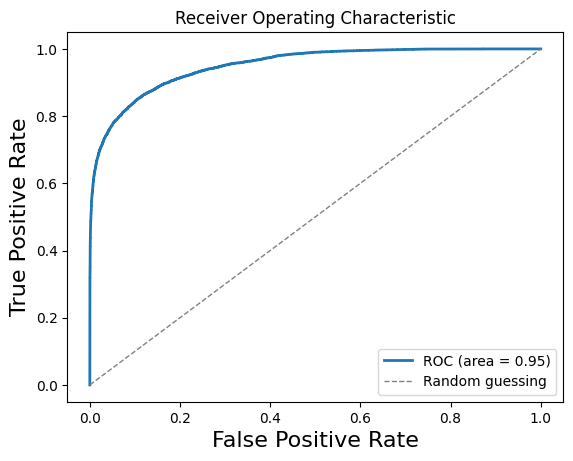

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, lw=2, label='ROC (area = %0.2f)' % roc_auc)

# plot the random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')

# set the plot title and axis labels
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend()

# show the plot
plt.show()


In [10]:
from scipy import stats
import tqdm

def get_set_of_list_elements(dictionary):
    elements = []
    for value in dictionary.values():
        if isinstance(value, list):
            elements.extend(value)
    return set(elements)

lk = list(library.keys())

rr = random.choices(lk, k=2000)
all_genes = get_set_of_list_elements(library)
scores = []
scores_all = []

for l in tqdm.tqdm(rr):
    lib_genes = library[l]
    if len(lib_genes) > 25:
        
        test_set = random.sample(lib_genes, int(len(lib_genes)/6))
        test_set.extend(random.sample(list(all_genes), len(lib_genes)*2))
        try:
            test_set_lib = {}
            test_set_lib["test"] = test_set

            test_embedding = genemap.embed_library(test_set_lib)

            library_embedding_temp = library_embedding.copy()

            lib_keys = [k for k in library.keys()]

            for i, x in enumerate(library_embedding_temp):
                library_embedding_temp[i, :] = library_embedding_temp[i, :] - test_embedding[0]

            y_pred_test = model.predict(library_embedding_temp)
            pred_res = pd.DataFrame(data=np.array(y_pred_test), index=lib_keys)
        
            result = enrichr.get_enrichment_results(test_set, "GO_Biological_Process_2021")
            res = result.set_index("Term")
            #inter = res.index.intersection(pred_res.index)
            scores.append(stats.zscore(pred_res.iloc[:,0]).loc[l])
            scores_all.extend(stats.zscore(pred_res.iloc[:,0]))
        except Exception:
            #print("error")
            xx=0

#plt.scatter(-np.log(res.loc[inter, "P-value"]), stats.zscore(pred_res.loc[inter,:].iloc[:,0]), s=1)


100%|██████████| 2000/2000 [10:12<00:00,  3.26it/s]


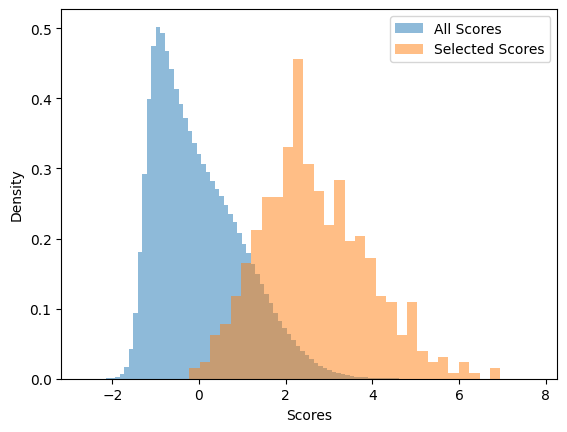

In [13]:
plt.hist(scores_all, bins=100, density=True, alpha=0.5, label='All Scores')
plt.hist(scores, bins=30, density=True, alpha=0.5, label='Selected Scores')

# Adding labels and legend
plt.xlabel('Scores')
plt.ylabel('Density')
plt.legend()


In [16]:
from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(scores_all[0:len(scores)], scores)

# Print the test results
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 11605.0
p-value: 3.9629696415690314e-148


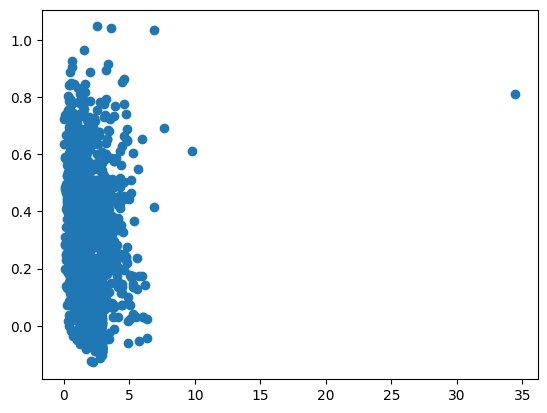

In [79]:
y_pred_test = model.predict(library_embedding_temp)
pred_res = pd.DataFrame(data=np.array(y_pred_test), index=lib_keys)

res = result.set_index("Term")
inter = res.index.intersection(pred_res.index)
plt.scatter(-np.log(res.loc[inter, "P-value"]), pred_res.loc[inter,:].iloc[:,0])


Text(0.5, 0, 'Features')

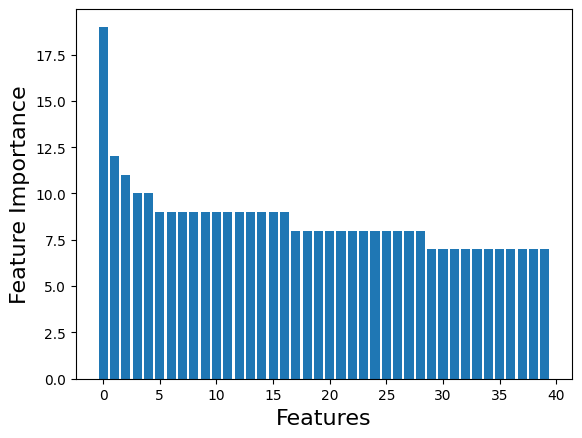

In [12]:
plt.bar(range(40), sorted(model.feature_importances_, reverse=True)[0:40])
plt.ylabel("Feature Importance", fontsize=16)
plt.xlabel("Features", fontsize=16)

Text(0, 0.5, 'Gene Set Size')

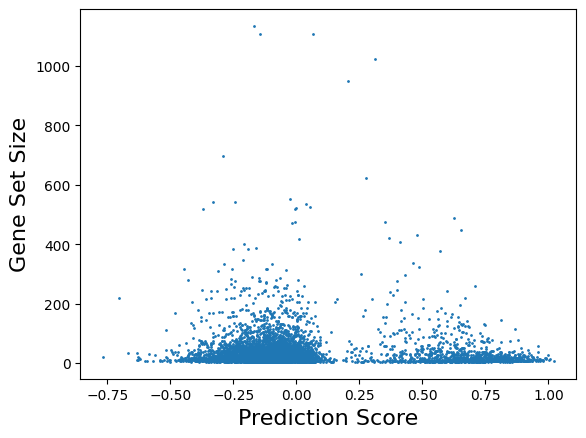

In [158]:
fig, ax = plt.subplots()
ax.scatter(y_test-y_pred, setsize[X_test.index], s=1)
ax.set_xlabel("Prediction Score", fontsize=16)
ax.set_ylabel("Gene Set Size", fontsize=16)

[Text(1, 0, 'False'), Text(2, 0, 'True')]

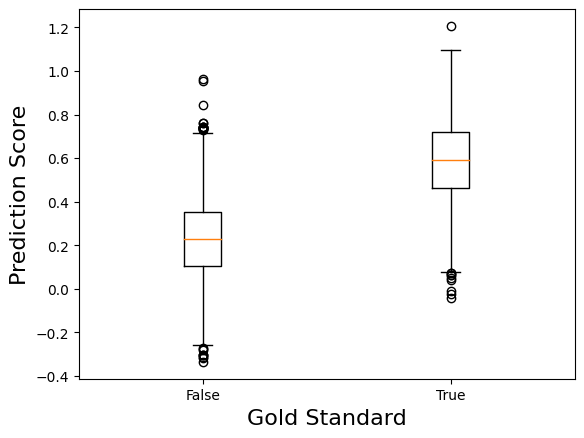

In [17]:

fig, ax = plt.subplots()
p = ax.boxplot([y_pred[y_test==0], y_pred[y_test==1]])
ax.set_ylabel("Prediction Score", fontsize=16)
ax.set_xlabel("Gold Standard", fontsize=16)
ax.set_xticklabels(["False", "True"])

In [19]:
with open('benchmark/data/kegg.gmt', 'r') as file:
    kegg = {line.split('\t')[0]: [item.rstrip() for item in line.split('\t')[2:]] for line in file}

In [21]:
kegg_embedding = genemap.embed_library(kegg)

100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


In [32]:
mapping = pd.read_csv("benchmark/data/d2d_map.txt", sep=" ", header=None, index_col=0)
i = mapping.index[1]
mm = np.array(mapping.loc[i,:])[0]
diff = pd.read_csv("benchmark/data/limma/"+i+".tsv", sep="\t", index_col=0).sort_values("limma.STAT", ascending=False)

gene_set = {}
gene_set["up"] = diff.index[0:100]
gene_set["down"] = diff.index[-100:]
set_embedding = genemap.embed_library(gene_set)
enrichment_input = []
for k in range(kegg_embedding.shape[0]):
    enrichment_input.append(np.array(kegg_embedding[k])+np.array(set_embedding[0]))
y_enrichment = model.predict(enrichment_input)
result = pd.DataFrame(np.array([np.array(list(kegg.keys())), np.array(y_enrichment)]).T, index=kegg.keys(), columns=["set", "pval"])

In [78]:
def rel_score2(enrichment_ranks, relevance_ranks):
    #enrich_rand = pd.DataFrame(enrichment_ranks)
    #enrich_rand.loc[:,"nes"] = random.sample(list(enrich_rand.loc[:, "nes"]), result.shape[0])
    enrichment_ranks["RANK"] = abs(enrichment_ranks.loc[:,"nes"])
    inter = enrichment_ranks.index.intersection(relevance_ranks.index)
    if len(inter) == 0:
        raise Exception("gene set identifier are not matching")
    return np.sum(enrichment_ranks.loc[inter,"RANK"]*relevance_ranks.loc[inter, "REL.SCORE"])

In [93]:
scores = []
rand_scores = []
mm_names = []
for i in mapping.index:
    rscore = []
    mm = np.array(mapping.loc[i,:])[0]
    mm_names.append(i+"-"+mm)
    rel_ranks = pd.read_csv("benchmark/data/mala/"+mm+".txt", sep="\t", index_col=0)
    diff = pd.read_csv("benchmark/data/limma/"+i+".tsv", sep="\t", index_col=0).sort_values("limma.STAT", ascending=False)

    gene_set = {}
    gene_set["up"] = diff.index[0:200]
    gene_set["down"] = diff.index[-200:]
    set_embedding = genemap.embed_library(gene_set)
    enrichment_input = []
    for k in range(kegg_embedding.shape[0]):
        enrichment_input.append(np.array(kegg_embedding[k])+np.array(set_embedding[0]))
    y_enrichment = model.predict(enrichment_input)
    result = pd.DataFrame(np.array(y_enrichment), index=kegg.keys(), columns=["nes"])
    scores.append(int(rel_score2(result, rel_ranks)))
    for k in range(100):
        rdata = pd.DataFrame(np.random.rand(result.shape[0]), index=result.index, columns=["nes"])
        rscore.append(int(rel_score2(rdata, rel_ranks)))
    rand_scores.append(rscore)

100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Text(0, 0.5, 'relevance')

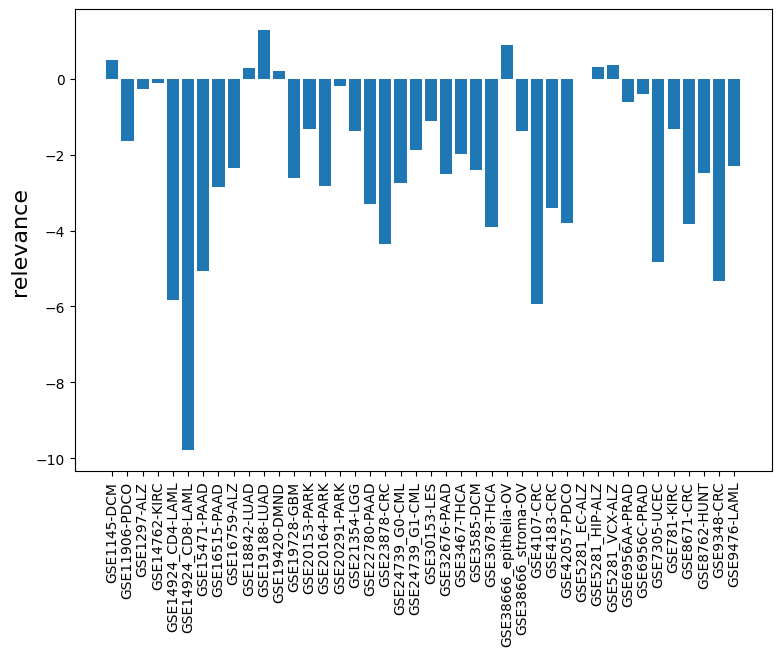

In [94]:
mr = np.mean(rand_scores, axis=1)
msd = np.std(rand_scores, axis=1)

plt.figure(figsize=(9,6))
plt.bar(range(len(msd)), (scores-mr)/msd)
plt.xticks(range(len(scores)), mm_names, rotation=90)
plt.ylabel("relevance", fontsize=16)

In [89]:
import blitzgsea as blitz
dd = diff["limma.STAT"].reset_index().sort_values("limma.STAT")
dd.columns = [0,1]
result_gsea = blitz.gsea(dd, kegg)

In [91]:
result

,nes,RANK
hsa00010,0.303087,0.303087
hsa00020,0.287834,0.287834
hsa00030,0.180619,0.180619
hsa00040,0.181200,0.181200
hsa00051,0.249897,0.249897
...,...,...
hsa05414,0.207051,0.207051
hsa05415,0.456276,0.456276
hsa05416,0.223543,0.223543
hsa05417,0.341394,0.341394


In [85]:
inter = result_gsea.index.intersection(result.index)
np.corrcoef(result_gsea.loc[inter,"nes"], result.loc[inter,"nes"])

array([[ 1.        , -0.05314387],
       [-0.05314387,  1.        ]])

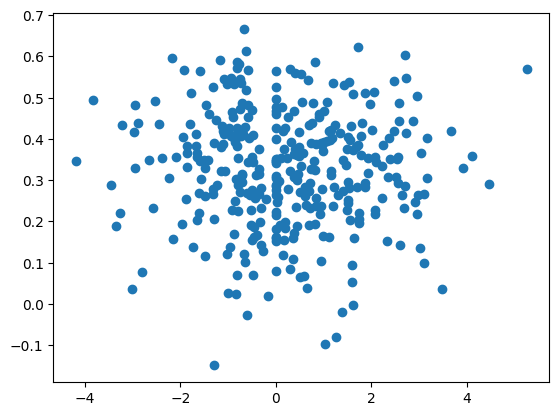

In [95]:
plt.scatter(result_gsea.loc[inter,"nes"], result.loc[inter,"nes"])

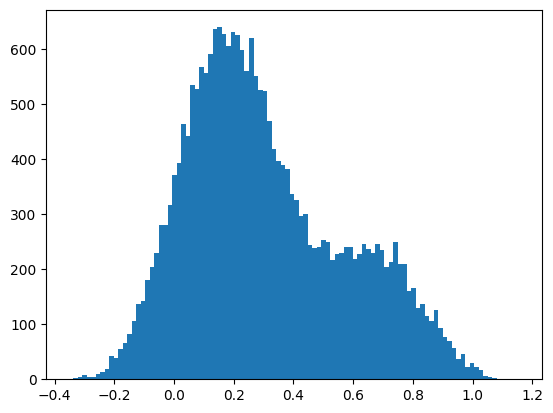

In [49]:
h = plt.hist(y_pred, bins=100)

In [61]:
result = pd.DataFrame(np.array([np.array(list(kegg.keys())), np.array(y_enrichment)]).T, index=kegg.keys(), columns=["set", "pval"])

,set,pval
hsa00010,hsa00010,0.4620420938559974
hsa00020,hsa00020,0.32165198314518556
hsa00030,hsa00030,0.24803624754512485
hsa00040,hsa00040,0.2452476713924271
hsa00051,hsa00051,0.36989222650144765
...,...,...
hsa05414,hsa05414,0.5738001948216627
hsa05415,hsa05415,0.5233052344496021
hsa05416,hsa05416,0.46155739345579594
hsa05417,hsa05417,0.2885194972153363
